# 📰 Analisis TF-IDF Artikel Garuda Indonesia

Notebook ini melakukan analisis **Term Frequency–Inverse Document Frequency (TF-IDF)** pada kumpulan artikel berita terkait **Garuda Indonesia**.  
Langkah utama mencakup:
1. Import dataset hasil preprocessing
2. Pembentukan matriks TF-IDF
3. Visualisasi hasil
4. Analisis Hasil

## 🔧 Import Library
Import pustaka utama untuk analisis teks dan visualisasi data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display  # pastikan sudah import ini

In [2]:
CSV_PATH   = "/content/7-garudaindonesia_news_cleaned_simple.csv"  # ganti kalau beda
TEXT_COL   = "konten_stem_clean"   # kolom yang dipakai
NGRAMS     = (1, 2)                # (1,1)=unigram, (1,2)=uni+bi, (1,3)=sampai trigram
MIN_DF     = 2                     # term minimal muncul di >=2 dokumen
MAX_DF     = 0.9                   # buang term yang muncul di >90% dokumen
MAX_FEATS  = 20000                 # batas fitur
TOP_K      = 30                    # top-K term global untuk ditampilkan
TOP_N_DOC  = 5                     # top-N per dokumen (opsional)
OUT_DIR    = "/content"            # tempat simpan CSV hasil

## 📂 Load Dataset
Membaca dataset hasil preprocessing artikel Garuda Indonesia.

In [3]:
# === 1) Load data ===
df = pd.read_csv(CSV_PATH)
assert TEXT_COL in df.columns, f"Kolom '{TEXT_COL}' tidak ada di CSV."
corpus = df[TEXT_COL].astype(str).fillna("").tolist()
print(f"Loaded {len(corpus)} dokumen.")

Loaded 469 dokumen.


## 🧮 TF-IDF Vectorization
Mengubah korpus teks menjadi representasi numerik berbasis **TF-IDF (Term Frequency – Inverse Document Frequency)** menggunakan `TfidfVectorizer` dari scikit-learn.


In [4]:
# -------- 2) Bangun TF-IDF --------
vectorizer = TfidfVectorizer(
    ngram_range=NGRAMS,
    min_df=MIN_DF,
    max_df=MAX_DF,
    max_features=MAX_FEATS,
    norm="l2"
)
X = vectorizer.fit_transform(corpus)     # sparse [n_docs, n_terms]
terms = np.array(vectorizer.get_feature_names_out())
idf   = vectorizer.idf_                  # IDF per term (urutan sama dgn 'terms')
print(f"Matrix shape (docs x terms): {X.shape}")

Matrix shape (docs x terms): (469, 19161)


## 📈 Visualisasi Top Terms
Menampilkan kata-kata (unigram) dengan nilai TF-IDF rata-rata tertinggi.  
Visualisasi ini menunjukkan istilah paling representatif dari seluruh korpus.


In [5]:
# -------- 3) Ringkasan global (ditampilkan) --------
# 3a) Top-K berdasarkan rata-rata TF-IDF global
mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
top_idx = np.argsort(mean_tfidf)[::-1][:TOP_K]
top_terms_df = pd.DataFrame({
    "term": terms[top_idx],
    "mean_tfidf": mean_tfidf[top_idx],
    "doc_freq": np.asarray((X[:, top_idx] > 0).sum(axis=0)).ravel(),
    "idf": idf[top_idx]
})
display(top_terms_df.style.hide(axis="index"))

term,mean_tfidf,doc_freq,idf
pesawat,0.065360,422,1.105361
terbang,0.041229,408,1.139018
tumpang,0.033204,245,1.647401
sebut,0.029663,384,1.199489
tiket,0.026659,121,2.348712
jadi,0.025020,351,1.289102
harga,0.024179,138,2.218259
armada,0.023163,171,2.005238
tambah,0.022971,216,1.772835
laku,0.022656,323,1.371989


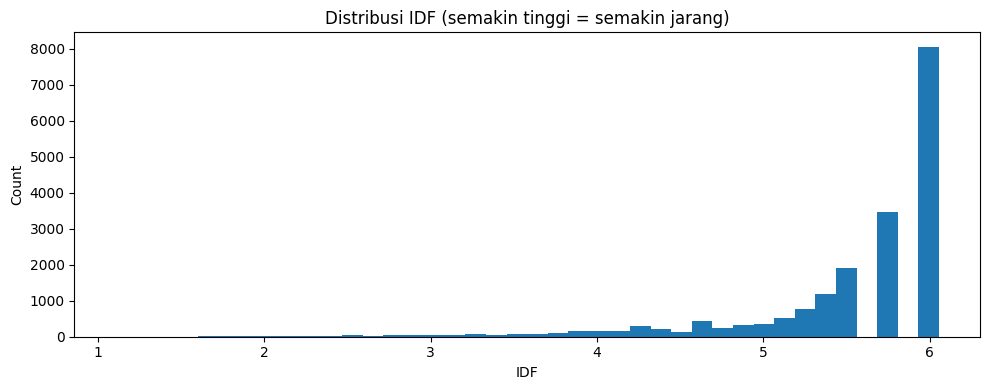

In [6]:
# 3b) Distribusi IDF (semakin tinggi → semakin jarang)
plt.figure(figsize=(10,4))
plt.hist(idf, bins=40)
plt.xlabel("IDF")
plt.ylabel("Count")
plt.title("Distribusi IDF (semakin tinggi = semakin jarang)")
plt.tight_layout()
plt.show()

In [7]:
# -------- 4) Viewer “semua term” (paging) --------
# kamu bisa lihat semua term, diurutkan by berbagai kriteria (tanpa menyimpan CSV)
full_df = pd.DataFrame({
    "term": terms,
    "idf": idf,
    "doc_freq": np.asarray((X > 0).sum(axis=0)).ravel(),
    "mean_tfidf": mean_tfidf
}).sort_values("mean_tfidf", ascending=False).reset_index(drop=True)

print(f"Total terms: {len(full_df)}")

Total terms: 19161


In [14]:
# Utils kecil biar kompatibel di pandas lama & baru
def _hide_idx(styler):
    try:
        # pandas >= 2.0
        return styler.hide(axis="index")
    except Exception:
        try:
            # pandas < 2.0
            return styler.hide_index()
        except Exception:
            return styler

def view_terms(page=1, per_page=50, sort_by="mean_tfidf", ascending=False):
    assert sort_by in {"mean_tfidf","idf","doc_freq","term"}
    temp = full_df.sort_values(sort_by, ascending=ascending).reset_index(drop=True)
    start = (page-1)*per_page
    end   = start + per_page
    print(f"Showing terms sorted by '{sort_by}' ({'asc' if ascending else 'desc'}) "
          f"— page {page}, rows {start}..{min(end, len(temp))-1}")
    subset = temp.iloc[start:end]
    display(_hide_idx(subset.style))

def top_terms_for_doc(doc_id, top_n=TOP_N_DOC):
    row = X.getrow(doc_id)
    if row.nnz == 0:
        print("Dokumen kosong atau tidak ada term setelah filter.")
        return
    idx_local = np.argsort(row.data)[-top_n:][::-1]
    term_idx = row.indices[idx_local]
    df_doc = pd.DataFrame({
        "term": terms[term_idx],
        "tfidf": row.data[idx_local]
    })
    display(_hide_idx(df_doc.style))

    # barchart kecil
    plt.figure(figsize=(10,4))
    plt.barh(df_doc["term"][::-1], df_doc["tfidf"][::-1])
    plt.xlabel("TF-IDF")
    plt.ylabel("Term")
    plt.title(f"Top {top_n} Terms — Doc {doc_id}")
    plt.tight_layout()
    plt.show()


term,tfidf
rupslb,0.228536
petinggi,0.197665
pegang saham,0.180741
singapore,0.176030
singapore airlines,0.176030
pegang,0.173203
saham,0.170918
direktur uang,0.169868
reza,0.166878
rupslb tengah,0.155645


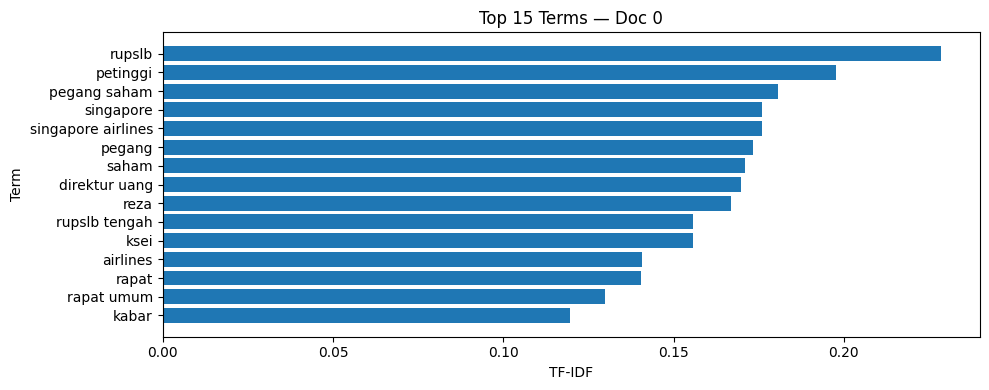

In [16]:
# Setelah cell TF-IDF vectorizer (X, terms siap)
doc_id = 0
top_terms_for_doc(doc_id, top_n=15)


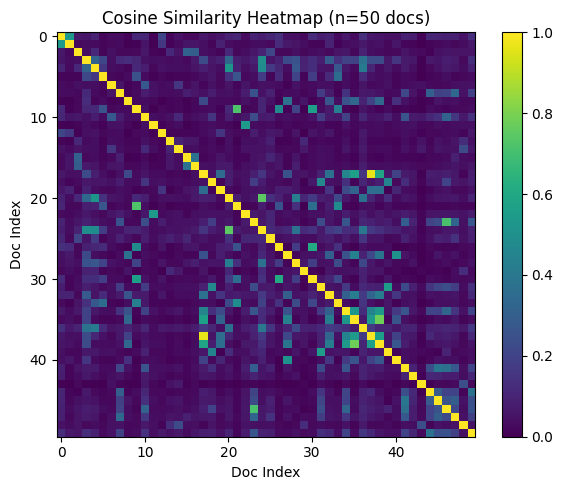

In [10]:
# untuk menghindari berat, pakai subset SAMPLE_SIM dokumen pertama (atau acak)

SAMPLE_SIM = 50
n = min(SAMPLE_SIM, X.shape[0])
if n >= 2:
    # ambil subset dokumen
    X_sub = X[:n]
    sim = cosine_similarity(X_sub)
    plt.figure(figsize=(6,5))
    plt.imshow(sim, aspect="auto")
    plt.title(f"Cosine Similarity Heatmap (n={n} docs)")
    plt.xlabel("Doc Index")
    plt.ylabel("Doc Index")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

bigram,mean_tfidf
harga tiket,0.016627
pesawat garuda,0.015576
tiket pesawat,0.013722
pt garuda,0.010611
rp juta,0.010392
rokok elektrik,0.009807
beli pesawat,0.009672
pesawat boeing,0.009489
turun harga,0.009418
direktur utama,0.009243


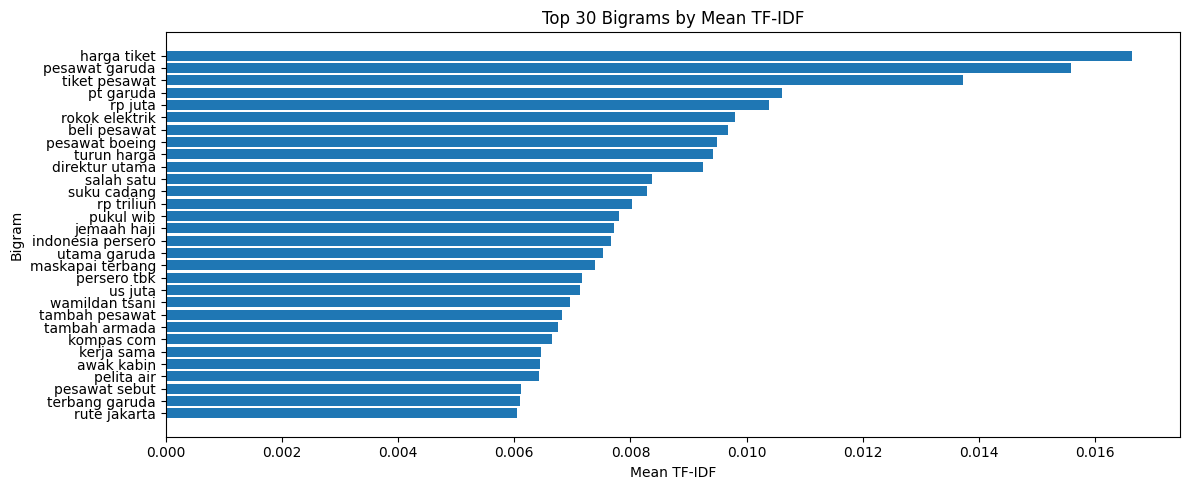

In [11]:
# -------- 7) (Opsional) Bigram TOP-K global --------
# (frasa umum: pilih term yang mengandung spasi → itu n-gram >= 2)
if NGRAMS[1] >= 2:
    # robust check untuk bigram+ (tanpa np.char.find)
    bigram_mask = np.array([' ' in t for t in terms])   # True jika term memuat spasi
    mean_bi = mean_tfidf[bigram_mask]
    terms_bi = terms[bigram_mask]

    if len(terms_bi) > 0:
        top_bi_idx = np.argsort(mean_bi)[::-1][:TOP_K]
        df_bi = pd.DataFrame({
            "bigram": terms_bi[top_bi_idx],
            "mean_tfidf": mean_bi[top_bi_idx]
        })

        styler = df_bi.style
        # kompatibel semua versi pandas
        display(styler.hide_index() if hasattr(styler, "hide_index") else styler.hide(axis="index"))

        plt.figure(figsize=(12, 5))
        plt.barh(df_bi["bigram"][::-1], df_bi["mean_tfidf"][::-1])
        plt.xlabel("Mean TF-IDF")
        plt.ylabel("Bigram")
        plt.title(f"Top {TOP_K} Bigrams by Mean TF-IDF")
        plt.tight_layout()
        plt.show()
